# [E10] 뉴스 요약봇 만들기

### 목차
1. 데이터 수집하기
2. 데이터 전처리
3. 훈련 데이터와 테스트 데이터 분리
4. 정수 인코딩
5. 모델 설계하기
6. 모델 훈련하기
7. 모델 테스트하기
8. 추출적 요약
9. 회고
  
---
  
### 루브릭 평가 기준
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
    * 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
    * 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.
    * 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.

## 1. 데이터 수집하기

### 1.1 데이터 준비

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

* NLTK 패키지에서 불용어 사전 다운로드
* urllib을 이용하여 뉴스 기사 데이터를 다운로드

In [3]:
data.sample(10)

,headlines,text
52735,Kerala shelter home director rearrested for ra...,The Kerala Police has arrested a man for alleg...
42424,"Reliance Jio, Saavn to create $1 bn music stre...",Reliance Industries has signed a deal to buy o...
31633,Jinnah was a 'maha purush' and will remain one...,Amid the ongoing controversy over Mohammad Ali...
54967,India jump to No. 2 in T20I rankings post SL s...,India jumped to the second spot in the ICC T20...
89019,Dwayne Johnson kisses Priyanka Chopra at Baywa...,Actor Dwayne Johnson kissed his Baywatch co-st...
91984,Gaga called Princess Diana just another dead b...,Singer Lady Gaga in her 2013 song Princess Die...
45888,"Maha CM, wife appear in video on saving Mumbai...",Maharashtra CM Devendra Fadnavis and his wife ...
11991,Qualcomm says Apple $7 billion behind in royal...,Qualcomm on Friday said that Apple is $7 billi...
26474,Steve Smith once asked pacer to break my ribs:...,Indian spinner Kuldeep Yadav has revealed Stev...
81409,What would happen if something crossed a black...,According to British physicist Stephen Hawking...


* 뉴스 기사 데이터가 어떻게 이루어져 있는지 확인하기 위해서, 10개의 sample을 출력
* 해당 데이터는 headlines와 text로 이루어져 있는 데이터임을 확인

In [4]:
print('Total number of sample :',(len(data)))
print(data.loc[0]['headlines'])
print(data.loc[0]['text'])

Total number of sample : 98401
upGrad learner switches to career in ML & Al with 90% salary hike
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.


* 총 데이터의 갯수는 98,401개이며, headlines와 text로 이루어져 있음

## 2. 데이터 전처리

In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


* 중복되는 데이터를 제외한 데이터의 갯수를 확인
* headlines는 text의 요약이므로, 동일한 요약들이 존재할 수 있음
* 그러나, text 자체가 중복이 된 경우는 중복 샘플이므로 제거해야함

In [6]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플 수 :',(len(data)))

전체 샘플 수 : 98360


* text의 중복 샘플을 drop_duplicates()를 이용하여 제거
* 총 98,401개의 데이터 중, 41개의 중복 text를 제거하여 총 98360개의 유니크한 샘플을 이용할 예정

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


* dataframe 내 NULL 값이 존재하는지 확인
* headlines와 text에 NULL 값이 존재하지 않으므로, 별다른 처리 과정 없이 사용

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


* text normalization
* 같은 의미이지만 다른 표현으로 사용되는 단어들을 같은 단어로 통일시켜주는 역할
* text 정규화를 위한 사전을 구성

In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

* NLTK에서 제공하는 불용어 리스트를 참조하여, 샘플에서 불용어를 제거할 예정
* 불용어 리스트에는 총 179개의 불용어가 존재

In [10]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

* preprocess_sentence(): 텍스트 전처리 함수
* text 소문자화, html 태그 제거, 괄호로 둘러 쌓여 있는 문자열 제거, 쌍따옴표와 따옴표 제거, 약어 정규화, 쇼유격 제거, 영어 외 문자 공백으로 변환, m이 3개 이상이면 2개로 변경하는 과정을 거침
* 이후, if 조건문을 이용하여 text에 있는 불용어를 제거하고, headlines에 있는 불용어는 제거하지 않음

In [11]:
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

* 전체 text에 대하여 전처리 과정을 거침
* 전처리 과정을 거친 text 데이터는 clean_text라는 빈 리스트에 추가

In [12]:
clean_headlines = []

for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False)) # 불용어를 제거하지 않습니다.

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

* 전체 headlines에 대하여 전처리 과정을 거침
* 전처리 과정을 거친 headlines 데이터는 clean_headlines 이라는 빈 리스트에 추가

In [13]:
data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('', np.nan, inplace=True)

* dataframe의 text와 headlines 열의 데이터들을 전처리 과정을 거친 clean_text와 clean_headlines 데이터로 바꿈
* dataframe에 빈 문자열이 존재하는 경우, NULL 값으로 변환

In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

* dataframe 내에 NULL 값이 존재하는지 확인

## 3. 훈련 데이터와 테스트 데이터 분리

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


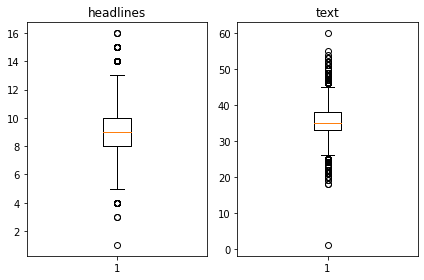

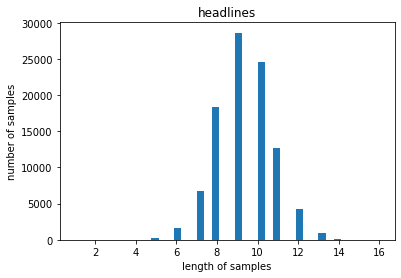

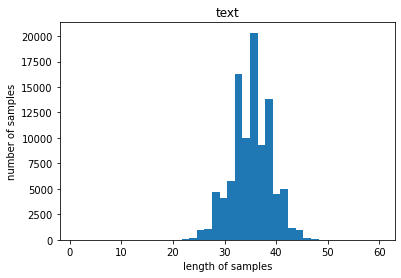

In [15]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* text와 headlines의 최소, 최대, 평균 길이를 확인하고 길이 분포를 시각화
* text의 경우, 최소 길이와 최대 길이의 차이가 크지만, 대체적으로 25 ~ 45 사이의 길이를 갖는다는 것을 그래프를 통해 확인
* headlines의 경우, 최소 길이와 최대 길이의 차이가 크지 않고, text에 비해 길이가 상대적으로 짧음

In [16]:
text_max_len = 45
headlines_max_len = 13

* text와 headlines의 적절한 최대 길이를 임의로 설정

In [17]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


* 이전에 정한 최대 길이를 기준에 포함되는 text와 headlines의 비율을 계산하는 함수
* text와 headlines의 약 99% 이상의 데이터들이 포함되는 것을 확인

In [19]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플 수 :',(len(data)))

전체 샘플 수 : 97863


* 이전에 설정한 최대 길이보다 짧은 text, headlines만 dataframe에 남겨놓음
* 설정한 최대 길이보다 긴 데이터들은 dataframe에서 제외
* 최종적으로 남는 샘플의 수는 97,863개

In [20]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


* 요약 데이터에 시작 토큰과 종료 토큰을 추가
* 디코더에서 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측하는 순간 문장 생성을 멈춤

In [21]:
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

* 인코더의 입력, 디코더의 입력, 디코더의 레이블을 numpy 타입으로 dataframe에 저장

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[24759 80887 32385 ... 72385 69610 11070]


* 훈련 데이터와 테스트 데이터를 분리하기 전에, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 선언

In [23]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

* 앞서 만든 정수 시퀀스를 이용하여, 데이터의 샘플 순서를 정의
* 샘플을 섞어주는 역할을 수행

In [24]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19572


* 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리할 예정
* 전체 데이터 크기에 0.2를 곱하여, 테스트 데이터의 크기를 정의

In [25]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :',len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


* 앞서 정의한 테스트 데이터의 갯수를 이용하여 전체 데이터를 훈련 데이터와 테스트 데이터로 양분
* 총 훈련 데이터는 78,291개이고, 테스트 데이터는 19,572개

## 4. 정수 인코딩

In [26]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

* keras 토크나이저 정의
* 토크나이저를 이용하여, 입력된 데이터로부터 단어 집합을 생성

In [27]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69172
등장 빈도가 6번 이하인 희귀 단어의 수: 47107
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22065
단어 집합에서 희귀 단어의 비율: 68.10125484300006
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4844656265128138


* threshold를 설정하여, 등장 빈도가 7회 미만인 단어들의 갯수를 카운트
* 또한, 전체 단어의 빈도수 총합과 threshold보다 빈도수가 작은 단어의 등장 빈도수의 총합을 출력
* 해당 코드를 통해서, 데이터 내 각 단어의 등장 빈도수를 확인
* threshold 보다 빈도수가 적은 단어의 갯수는 47,107개로 약 68%
* 등장 빈도가 threshold 보다 작은 단어들은 정수 인코딩 과정에서 제외하고, 훈련 데이터에서 제거할 예정

In [28]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

* 등장 빈도가 threshold 보다 적은 단어들을 제외한 단어 집합의 크기가 22,065개 이므로, 단어 집합의 크기를 20,000으로 설정
* 단어 집합의 크기를 이용하여, 단어 집합을 재생성

In [29]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[28, 2715, 102, 8651, 10968, 891, 1616, 253, 91, 716, 253, 2962, 14759, 1418, 3054, 2755, 4389, 1460, 5790, 28, 253, 102, 1222, 7047, 1611, 891, 5790, 2715, 253, 9431, 468, 20, 208, 8651, 280, 5790, 2715, 280, 91], [1114, 64, 53, 765, 3649, 152, 140, 12899, 85, 1162, 111, 4241, 2172, 1052, 152, 41, 629, 631, 64, 205, 698, 2665, 9, 411, 77, 291, 2172, 12899], [1238, 112, 7854, 1879, 256, 3377, 8791, 1332, 366, 3183, 497, 54, 30, 1579, 97, 2333, 4318, 5169, 5461, 3377, 366, 246, 11242, 2179, 1955, 934, 144, 24, 72, 225, 2032, 28, 5323, 2032, 370, 249, 14222]]


* 텍스트 시퀀스를 정수 시퀀스로 변환하고, 샘플을 출력하여 확인

In [30]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

* keras의 토크나이저를 이용하여, decoder_input에 대해서도 encoder_input과 똑같은 작업을 수행

In [31]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29982
등장 빈도가 5번 이하인 희귀 단어의 수: 19559
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10423
단어 집합에서 희귀 단어의 비율: 65.2358081515576
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.645335915868936


* threshold를 설정하여, 등장 빈도가 6회 미만인 단어들의 갯수를 카운트
* 또한, 전체 단어의 빈도수 총합과 threshold보다 빈도수가 작은 단어의 등장 빈도수의 총합을 출력
* 해당 코드를 통해서, 데이터 내 각 단어의 등장 빈도수를 확인
* threshold 보다 빈도수가 적은 단어의 갯수는 19,559개로 약 65%
* 등장 빈도가 threshold 보다 작은 단어들은 정수 인코딩 과정에서 제외하고, 훈련 데이터에서 제거할 예정

In [32]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 5017, 3, 1311, 4823, 3482, 1218, 473, 2582, 11], [1, 39, 1002, 83, 2303, 122, 5, 181, 3, 5416], [1, 394, 1219, 644, 3, 2036, 271, 1890, 131, 117, 590], [1, 886, 65, 299, 24, 46, 1099, 520, 6461, 3, 146], [1, 2542, 670, 4, 81, 5417, 6785, 4, 47, 1393, 36]]
target
decoder  [[5017, 3, 1311, 4823, 3482, 1218, 473, 2582, 11, 2], [39, 1002, 83, 2303, 122, 5, 181, 3, 5416, 2], [394, 1219, 644, 3, 2036, 271, 1890, 131, 117, 590, 2], [886, 65, 299, 24, 46, 1099, 520, 6461, 3, 146, 2], [2542, 670, 4, 81, 5417, 6785, 4, 47, 1393, 36, 2]]


* 등장 빈도가 threshold 보다 적은 단어들을 제외한 단어 집합의 크기가 10,423개 이므로, 단어 집합의 크기를 10,000으로 설정
* 단어 집합의 크기를 이용하여, 단어 집합을 재생성
* 텍스트 시퀀스를 정수 시퀀스로 변환하고, 샘플을 출력하여 확인

In [33]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :',len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78290
훈련 레이블의 개수 : 78290
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


* 요약문의 길이가 1인 경우 삭제

In [34]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

* 서로 다른 길이의 샘플들을 병렬 처리하기 위해서, 패딩을 이용하여 같은 길이로 맞춰주는 작업을 진행

## 5. 모델 설계하기

In [35]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

* 임베딩 벡터의 차원을 128로 정의하고, hidden state의 크기를 256으로 정의
* 이후, 인코더 부분의 LSTM은 총 3개의 층으로 구성
* 인코더의 최종 출력 벡터는 디코더로 보낼 예정

In [36]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

* 디코더의 임베딩 층을 설계하는 것은 인코더와 동일
* LSTM 층은 initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줌

In [37]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

* model에서 어텐션 함수를 이용할 예정이므로, 어텐션 함수를 다운로드

In [38]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

* 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 이용
* 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동

## 6. 모델 훈련하기

In [39]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', patience = 2, verbose=1)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 512, callbacks=[es], epochs = 50)

Epoch 1/50
153/153 [==============================] - 163s 985ms/step - loss: 5.8887 - val_loss: 5.0055
Epoch 2/50
153/153 [==============================] - 150s 983ms/step - loss: 4.9778 - val_loss: 4.7495
Epoch 3/50
153/153 [==============================] - 150s 982ms/step - loss: 4.7066 - val_loss: 4.4807
Epoch 4/50
153/153 [==============================] - 151s 986ms/step - loss: 4.4215 - val_loss: 4.2504
Epoch 5/50
153/153 [==============================] - 151s 988ms/step - loss: 4.1790 - val_loss: 4.1038
Epoch 6/50
153/153 [==============================] - 150s 981ms/step - loss: 3.9955 - val_loss: 3.9760
Epoch 7/50
153/153 [==============================] - 151s 986ms/step - loss: 3.8373 - val_loss: 3.8823
Epoch 8/50
153/153 [==============================] - 151s 988ms/step - loss: 3.7061 - val_loss: 3.7971
Epoch 9/50
153/153 [==============================] - 151s 985ms/step - loss: 3.5877 - val_loss: 3.7303
Epoch 10/50
153/153 [==============================] - 150s 983m

* 설계한 model을 훈련
* early stopping 기능을 이용하여, validation loss가 증가하는 현상이 2회 관측될 시, 학습을 종료
* 최종적으로, model이 최적점에서 훈련을 종료하는 역할을 수행
* model의 loss는 약 2.2899이지만, validation loss는 3.3406으로 둘 사이의 격차가 큼

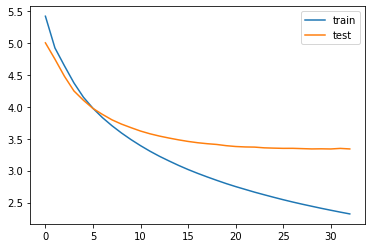

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

* 훈련 데이터와 테스트 데이터의 loss를 시각화
* 훈련 데이터와 테스트 데이터 loss의 격차를 보면, 훈련 데이터가 overfitting이 되었다고 판단할 수 있음

## 7. 모델 테스트하기

In [41]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

* 정수 인덱스 행렬로 존재하는 텍스트 데이터를 실제 데이터로 복원할때 사용할 3개의 사전을 준비

In [42]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

* 훈련과 달리 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복적으로 동작해야함
* 따라서 인퍼런스를 위한 모델을 별도로 설계
* 이때는, 인코더 모델과 디코더 모델을 분리하여 설계해야함

In [43]:
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

* 어텐션 함수를 사용하는 출력층을 설계

In [44]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

* 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [45]:
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

* 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수
* text의 경우, 패딩을 위해 사용한 숫자 0을 제외
* headlines의 경우, 숫자 0, 시작 토큰, 종료 토큰의 인덱스를 출력에서 제외

In [46]:
for i in range(10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : hollywood actor sylvester stallone talking rambo hindi remake wrote sure tiger put heart soul derivatives always one eye tiger us cubs rule jungle tiger responded stallone played lead rambo series four films 
실제 요약 : tiger will put his heart soul into remake sylvester 
예측 요약 :  was not just just just so much on my life wars huma


원문 : large sized enterprise india loses average million annually owing cyber attacks microsoft led study said wednesday cybersecurity attacks also result job losses across different functions three five organisations study added companies face risk significant financial loss market reputation microsoft official said 
실제 요약 : cyber attacks cost big indian firms mn year microsoft 
예측 요약 :  india opens bn in china over data breach


원문 : people believe halloween celebrated october festival celebrated towards end harvest season believed barrier spirit living world time later christian religion halloween came called eve 
실제 요약 : what is the origin of hallowee

* 10개의 샘플을 출력하여, 실제 headlines와 예측된 headlines를 비교
* 일부 샘플에 대해서는, 실제 headlines와 비슷한 headlines를 예측
* 실제 headlines에서는 사용하지 않은 단어를 이용하여 예측한 headlines도 존재
* 그러나, 일부 샘플에 대해서 좋지 않은 예측을 보이는 샘플도 존재
* 따라서, 모델의 성능 개선이 필요

## 8. 추출적 요약

In [47]:
from summa.summarizer import summarize
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

* 앞서 seq2seq를 이용한 추상적 요약이 아닌, Summa 패키지를 이용한 추출적 요약을 진행
* Summa의 summarizer 모듈을 이용
* 매트릭스 시놉시스를 다운로드

In [48]:
data['summary'] = data['text'].apply(lambda x: summarize(x, ratio=0.5))

* summarize을 이용하여 만든 추출적 요약을 dataframe에 추가

In [49]:
data.sample(10)

,headlines,text,summary
41789,Kim Jong-un invites Chinese President to visit...,North Korean leader Kim Jong-un invited China'...,North Korean leader Kim Jong-un invited China'...
58375,No evidence Pak knew about Osama bin Laden's p...,"The US government had been able to find ""no ev...","The US government had been able to find ""no ev..."
51173,Global IT spending to reach $3.7 trillion in 2...,Global IT spending is projected to rise 4.5% f...,Global IT spending is projected to rise 4.5% f...
55783,Virat Kohli asks Rohit Sharma to share 'double...,After Rohit Sharma offered Virat Kohli a 'husb...,After Rohit Sharma offered Virat Kohli a 'husb...
47741,SpaceX's satellite internet plan gets backing ...,The US Federal Communications Commission (FCC)...,The US Federal Communications Commission (FCC)...
85120,Indian football team registers its 8th consecu...,India defeated Kyrgyz Republic 1-0 in the AFC ...,"Both teams struggled to find the net, before I..."
94543,Drunk drivers may have to pay entire compensat...,As per the Motor Vehicles (Amendment) Bill int...,As per the Motor Vehicles (Amendment) Bill int...
23216,Boeing delays 1st crewed spacecraft test fligh...,Aerospace company Boeing has delayed its first...,Aerospace company Boeing has delayed its first...
20186,"Move aside Sonam, family has 2 new fashion reb...",Sharing his sisters Anshula Kapoor and Khushi ...,
19433,Rajasthan to cut teachers' salary if they miss...,Rajasthan's education department has warned th...,Rajasthan's education department has warned th...


* dateframe에 추출적 요약 데이터가 정상적으로 추가되었는지 확인

In [50]:
for i in range(10):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("추출 요약 :", data['summary'][i])
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출 요약 : Users get one CRED coin per rupee of bill pai

* 10개의 샘플을 출력하여, 실제 headlines와 추출적 요약 방법으로 예측한 headlines를 비교
* 실제 headlines와는 다르지만, 어느 정도 원문을 잘 요약했다고 판단
* 그러나, 내용과는 상관없이 보이는 문제는 예측된 headlines의 길이가 너무 길다고 판단
* 이러한 문제는 summarize의 인자인 ratio를 줄이면 해결할 수 있음

## 9. 회고

* model의 학습 결과를 보면, validation loss가 3.3406으로 큰 값을 가지며, loss와 validation loss 간의 격차가 큰 것을 확인할 수 있다. 아마도 model이 학습 데이터에 overfitting이 된 것이 아닌가 생각한다. 해당 노드에서 overfitting을 줄이기 위한 방법으로, 모델의 층을 늘리는 방법이 존재할 것 이다. 또는 hyperparameter를 조절하는 방법도 존재할 것이다. epoch 수를 늘리는 것은 early_stoping 기능으로 인해서 큰 의미는 없을 것으로 판단된다. 그러나, 이러한 방법들은 model의 성능을 드라마틱하게 향상시키지는 못할 것으로 예측된다. 그렇다면, 성능을 향상시키기 위해서 어떤 방법을 사용해야할까? 이전 NLP 노드에서 항상 고려하던 bidirectional LSTM을 사용해야 하는가? 이번 노드에서도 dropout을 적용시킬 수 있을까? model의 loss 수치 뿐만 아니라, model이 최종적으로 예측한 요약문들을 보면, 정말로 이 model을 신뢰할 수 있는가에 대해서도 의문이 든다. 글이라는 것은 보는 사람에 따라서 해석이 달라지고, 받아들이는 것이 달라진다고 생각한다. 이런 관점에서 본다면, NLP model을 얼마나 신뢰할 수 있을까? 어쩌면 이번 노드의 데이터가 영문이기 때문에, 내가 이해하지 못하는 것 일수도 있다. 그러나, 항상 NLP 노드를 진행하다보면 드는 의문점들은 비슷한 것 같다. model과 예측 결과에 대한 신뢰성. NLP에 흥미를 갖지 못하는 것도 이러한 궁금증이 해결되지 않았기 때문이라고 생각된다. 이러한 근본적인 의문을 해결할 수 있는 방법이 무엇일지 모르겠다.
  
---
  
* 추상적 요약의 경우, 원문과는 상관없는 엉뚱한 요약을 예측한 경우도 존재했다. 원문과 무관한 단어를 사용하는 경우도 존재했는데, 이런 예측이 출력된 이유는 잘 모르겠다. 어쩌면, 이러한 문제들이 하나씩 모여서 내가 NLP model를 신뢰할 수 없는 것이 아닌가 생각한다.
   
   
* 반면, 추출적 요약의 경우, 원문에 있는 단어들을 가져오는 방식이기 때문에, 추상적 요약에 비해서 원문과 비슷했다. 문법적으로도 이상한 점을 크게 느끼지는 못했다. 그러나 예측된 요악문 자체를 보고 생각해보면, 원문의 핵심을 잘 요약했는가에 대한 의문이 생긴다. 그래도 상대적으로 요약을 잘 했고, 어느정도 키포인트를 잘 캐치했다고 생각이 든다.
  
  
* 원문을 정확하게 요약해야 하는 경우라면 추출적 요약을 쓰는 것이 더 적합하다는 생각이 든다. 하지만, 실제로 요약이라는 것은 원문의 키포인트를 잘 캐치하고, 원문의 내용과 일치하는 내용이어야하며, 원문보다는 짧게 핵심을 잘 전달해야한다. 이런 기준에서 본다면 추상적 요약을 사용할 필요가 있는가에 대해서 의문이 든다.

---
   
   
* 개인적으로 NLP 노드는 진행할때마다 의문 투성이다. NLP의 필요성이나 중요성에 의문이 드는 것은 아니지만, 과연 model을 얼마나 신뢰할 수 있는가에 대해서 의문이 든다. NLP에 대한 의문들을 어떻게 해소할 수 있을지에 대해 고민을 해봤지만, 아직은 잘 모르겠다. 내가 CV에 관심이 있다고 하더라도, NLP에 대한 공부를 소홀히해서는 안될텐데... NLP에 대한 정보들을 더 많이 찾아봐야할 것 같다.